In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn

from torch import optim
from tqdm import tqdm
import dlc_practical_prologue as prologue

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
def to_one_hot(input, target):
    size = tuple(target.size()) + (int(target.max() + 1),)
    tmp = input.new_zeros(size)
    tmp.scatter_(tmp.dim()-1, target.unsqueeze(tmp.dim()-1), 1.0)
    return tmp

In [14]:
#################### MAIN NETWORK STRUCTURES, InLeNet and LinearDNN #############
class DigiNet(nn.Module): #InLeNet main network
    def __init__(self):
        super().__init__()

        self.feature_extractor = nn.Sequential(
            nn.Conv2d(1, 10, 5),
            nn.BatchNorm2d(10),
            #nn.Dropout2d(),
            nn.LeakyReLU(),
            nn.Conv2d(10, 20, 3),
            nn.BatchNorm2d(20),
            #nn.Dropout2d(),
            nn.LeakyReLU(),
            nn.Conv2d(20, 40, 3),
            nn.BatchNorm2d(40),
            #nn.Dropout2d(),
            nn.LeakyReLU()
        )

        self.feature_classifier = nn.Sequential(
            nn.Linear(40 * 6 * 6, 10),
            nn.BatchNorm1d(10),
            #nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(10, 50),
            nn.BatchNorm1d(50),
            #nn.Dropout(),
            nn.LeakyReLU(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

        self.net = nn.Sequential(
            self.feature_extractor,
            nn.Flatten(),
            self.feature_classifier
        )

    def forward(self, input):
        return self.net(input)
    
class DigiNet2(nn.Module): # Fully LinearDNN main network
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            
            nn.Linear(1 * 14 * 14, 256),
            #nn.BatchNorm1d(256), # Uncomment this to test BN on the network
            nn.PReLU(),
            
            nn.Linear(256, 64),
            #nn.BatchNorm1d(64),
            nn.PReLU(),
            
            nn.Linear(64, 64),
            #nn.BatchNorm1d(64),
            nn.PReLU(),
            
            nn.Linear(64, 64),
            #nn.BatchNorm1d(64),
            nn.PReLU(),
            
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
            )

    def forward(self, x):
        digit = self.net(x.view(-1, 1*14*14))
        return digit

    
class PairNet(nn.Module): # Full network for InLeNet network
    def __init__(self, aux_loss=False, weight_sharing=False):
        super().__init__()
        self.aux_loss = aux_loss
        self.weight_sharing = weight_sharing

        self.net1 = DigiNet()
        # Network-level weight sharing
        self.net2 = self.net1 if weight_sharing else DigiNet()
        self.feature_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100, 1)
        )

    def forward(self, input):
        image1, image2 = input[:100].split(1, dim=1)
        output1 = self.net1(image1)
        output2 = self.net2(image2)
        aux = torch.cat((output1.unsqueeze(1), output2.unsqueeze(1)), 1)

        # I used another feature classifier here
        # We could (but it my be bad) predict the digit
        # by directly taking the argmax of digit1 and digit2
        # (i.e. index of the maximum value, between 0 et 9).
        # We could also use a more complex classifier.
        x = torch.bmm(output1.unsqueeze(2), output2.unsqueeze(1))
        res = self.feature_classifier(x).flatten()

        return res.float(), aux.float()

    
class PairNet2(nn.Module): # Full network for LinearDNN network
    def __init__(self, aux_loss=False, weight_sharing=False):
        super().__init__()
        self.aux_loss = aux_loss
        self.weight_sharing = weight_sharing

        self.net1 = DigiNet2()
        # Network-level weight sharing
        self.net2 = self.net1 if weight_sharing else DigiNet2()
        self.feature_classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100, 1)
        )

    def forward(self, input):
        image1, image2 = input[:100].split(1, dim=1)
        output1 = self.net1(image1)
        output2 = self.net2(image2)
        aux = torch.cat((output1.unsqueeze(1), output2.unsqueeze(1)), 1)

        # I used another feature classifier here
        # We could (but it my be bad) predict the digit
        # by directly taking the argmax of digit1 and digit2
        # (i.e. index of the maximum value, between 0 et 9).
        # We could also use a more complex classifier.
        x = torch.bmm(output1.unsqueeze(2), output2.unsqueeze(1))
        res = self.feature_classifier(x).flatten()

        return res.float(), aux.float()

In [5]:
########################   TRAINING + ERROR COUNTS   ##################################

def train_model(model, input, target, target_classes, mini_batch_size, nb_epochs=25):
    criterion = torch.nn.MSELoss()
    criterion_aux = torch.nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)

    train_loss, train_accuracy = [], []

    for _ in tqdm(range(nb_epochs)):
        epoch_loss, epoch_accuracy = 0, 0
        for b in range(0, input.size(0), mini_batch_size):
            input_batch  = input.narrow(0, b, mini_batch_size)
            target_batch = target.narrow(0, b, mini_batch_size)

            prediction, classes = model(input_batch)

            loss     = criterion(prediction, target_batch.float())
            accuracy = ((prediction > 0.5) == target_batch).sum()
            
            model.zero_grad()

            if model.aux_loss:
                classes_batch = target_classes.narrow(0, b, mini_batch_size)
                aux_loss = criterion_aux(classes, classes_batch)
                loss  += aux_loss

            loss.backward()
            optimizer.step()

            epoch_loss += loss
            epoch_accuracy += accuracy * 100 / len(target)
            
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)
    return train_loss, train_accuracy


def compute_nb_errors(model, input, target, mini_batch_size):
    nb_errors = 0
    for b in range(0, input.size(0), mini_batch_size):
        prediction, _ = model(input.narrow(0, b, mini_batch_size))
        predicted_target = torch.empty(prediction.size())
        for k in range(mini_batch_size):
            predicted_target[k] = 0.0 if prediction[k] < 0.5 else 1.0
            if target[b + k] != predicted_target[k]:
                nb_errors = nb_errors + 1
    return nb_errors


In [10]:

##############################   MAIN    ####################################

nb_rounds, nb_epochs, nb_models, batch_size = 20, 25, 4, 100

train_loss     = np.zeros((nb_models, nb_epochs))
train_accuracy = np.zeros((nb_models, nb_epochs))
test_error     = np.zeros(nb_models)

train_loss_matrix = np.zeros((nb_models, nb_rounds, nb_epochs))
train_accuracy_matrix = np.zeros((nb_models, nb_rounds, nb_epochs))

for round in range(nb_rounds):
    models = {
        'Vanilla'                        : PairNet2(False, False), # Change these between PairNet and PairNet2
        'Auxiliary Loss'                 : PairNet2(True , False), # to test out InLeNet and LinearDNN, respectively
        'Weight Sharing'                 : PairNet2(False, True),
        'Auxiliary Loss + Weight Sharing': PairNet2(True , True)
    }

    data = prologue.generate_pair_sets(1000)
    train_input, train_target, train_classes = data[:3]
    test_input , test_target,  test_classes  = data[3:]

    train_classes = to_one_hot(train_input, train_classes)
    test_classes = to_one_hot(test_input, test_classes)

    print(f'{round=}')
    for i, (_, model) in enumerate(models.items()):
        loss, accuracy = train_model(
            model, 
            train_input, train_target, 
            train_classes, 
            batch_size, nb_epochs
        )
        errors = compute_nb_errors(model, test_input, test_target, 100)
        
        with torch.no_grad():
            train_loss    [i] = train_loss[i] + np.array(loss)
            train_accuracy[i] = train_accuracy[i] + np.array(accuracy)
            test_error    [i] = errors / len(test_input) * 100
            train_loss_matrix[i, round, :] = np.array(loss)
            train_accuracy_matrix[i, round, :] = np.array(accuracy)
            


  8%|▊         | 2/25 [00:00<00:01, 17.46it/s]

round=0


  8%|▊         | 2/25 [00:00<00:02, 10.22it/s]

round=1


  0%|          | 0/25 [00:00<?, ?it/s]

round=2


  8%|▊         | 2/25 [00:00<00:01, 11.57it/s]

round=3


  8%|▊         | 2/25 [00:00<00:01, 18.38it/s]

round=4


  8%|▊         | 2/25 [00:00<00:01, 18.52it/s]

round=5


  8%|▊         | 2/25 [00:00<00:02, 10.50it/s]

round=6


  8%|▊         | 2/25 [00:00<00:01, 14.18it/s]

round=7


  8%|▊         | 2/25 [00:00<00:01, 14.94it/s]

round=8


  8%|▊         | 2/25 [00:00<00:02, 11.40it/s]

round=9


  8%|▊         | 2/25 [00:00<00:01, 16.06it/s]

round=10


  8%|▊         | 2/25 [00:00<00:01, 18.43it/s]

round=11


  8%|▊         | 2/25 [00:00<00:01, 18.46it/s]

round=12


  8%|▊         | 2/25 [00:00<00:01, 16.53it/s]

round=13


  8%|▊         | 2/25 [00:00<00:01, 13.23it/s]

round=14


  8%|▊         | 2/25 [00:00<00:02, 11.44it/s]

round=15


  8%|▊         | 2/25 [00:00<00:01, 15.07it/s]

round=16


  8%|▊         | 2/25 [00:00<00:01, 16.04it/s]

round=17


  8%|▊         | 2/25 [00:00<00:01, 16.09it/s]

round=18


  8%|▊         | 2/25 [00:00<00:01, 18.06it/s]

round=19


100%|██████████| 25/25 [00:01<00:00, 21.21it/s]



model.aux_loss=False, model.weight_sharing=False | error=45.90%

model.aux_loss=True, model.weight_sharing=False | error=13.80%

model.aux_loss=False, model.weight_sharing=True | error=45.90%

model.aux_loss=True, model.weight_sharing=True | error=7.70%


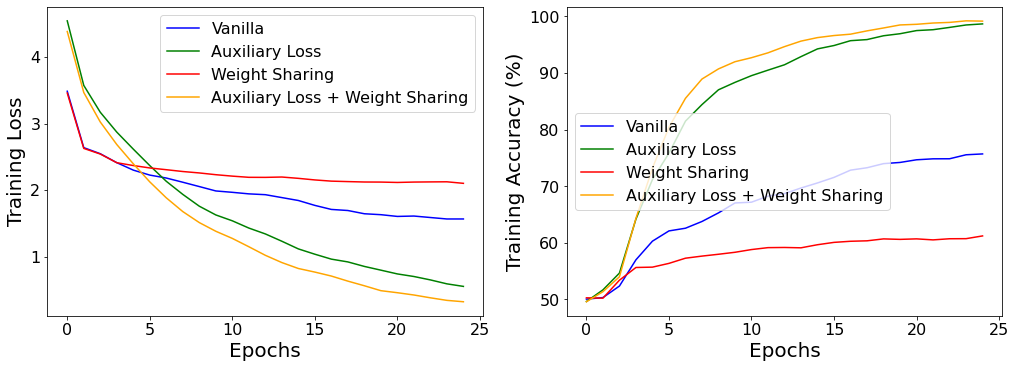

In [15]:
# Visualize results without std:

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(14, 5))
colors = ['blue', 'green', 'red', 'orange']    

for i, (name, model) in enumerate(models.items()):
    model    = model
    accuracy = train_accuracy[i] / nb_rounds
    loss     = train_loss[i] / nb_rounds
    error    = test_error[i]

    print(f"\n{model.aux_loss=}, {model.weight_sharing=} | {error=:.2f}%")
    axs[0].plot(loss, label=name, color = colors[i])
    axs[1].plot(accuracy, label=name, color = colors[i])

axs[0].legend(fontsize = 16)
axs[1].legend(fontsize = 16)
axs[0].tick_params(axis='both', labelsize= 16 )
axs[1].tick_params(axis='both', labelsize= 16 )
axs[0].set_xlabel('Epochs', fontsize = 20)
axs[1].set_xlabel('Epochs', fontsize= 20)
axs[0].set_ylabel('Training Loss', fontsize = 20)
axs[1].set_ylabel('Training Accuracy (%)', fontsize = 20)

#plt.savefig('convnet_results.pdf')
plt.show()


model.aux_loss=False, model.weight_sharing=False | error=45.90%
Training Error =  24.32 %

model.aux_loss=True, model.weight_sharing=False | error=13.80%
Training Error =  1.34 %

model.aux_loss=False, model.weight_sharing=True | error=45.90%
Training Error =  38.8 %

model.aux_loss=True, model.weight_sharing=True | error=7.70%
Training Error =  0.85 %


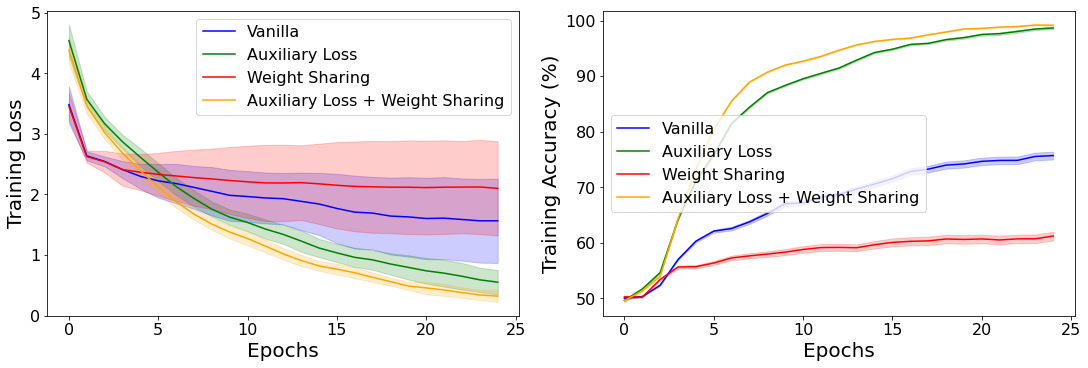

In [16]:
# Visualize results with std
colors = ['blue', 'green', 'red', 'orange']    

fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    model    = model
    accuracy = train_accuracy[i] / nb_rounds
    loss     = train_loss[i] / nb_rounds
    error    = test_error[i]
    up_loss = loss + train_loss_matrix[i].std(axis = 0)
    down_loss = loss - train_loss_matrix[i].std(axis = 0)
    up_acc = accuracy + train_loss_matrix[i].std(axis = 0)
    down_acc = accuracy - train_loss_matrix[i].std(axis = 0)
    print(f"\n{model.aux_loss=}, {model.weight_sharing=} | {error=:.2f}%")
    print('Training Error = ', np.round(100-accuracy[-1], 2), '%')
    axs[0].plot(loss, label=name, color = colors[i])
    axs[0].fill_between(range(nb_epochs), up_loss, down_loss, color=colors[i], alpha=.2)
    axs[1].plot(accuracy, label=name, color = colors[i])
    axs[1].fill_between(range(nb_epochs), up_acc, down_acc, color=colors[i], alpha=.2)


axs[0].legend(fontsize = 16)
axs[1].legend(fontsize = 16)
axs[0].set_xlabel('Epochs', fontsize = 20)
axs[1].set_xlabel('Epochs', fontsize = 20)
axs[0].set_ylabel('Training Loss', fontsize = 20)
axs[1].set_ylabel('Training Accuracy (%)', fontsize = 20)
axs[0].tick_params(axis='both', labelsize= 16 )
axs[1].tick_params(axis='both', labelsize= 16 )

#plt.savefig('LinearDNN_Batchnorm.pdf')
plt.show()